# Masking data

**Notebook currently compatible with both `NCI` and `DEA Sandbox` environments**

### Description
In this notebook, we demonstrate how to mask data (keep only certain pixels in an image) using boolean masks.
We will mask out clouds and cloud shadows to obtain an image made of clear pixels.

### Technical details
* **Products used:** [s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule)
* **Analyses used:** cloud mask, image dilation

## Getting started
First we import relevant packages and create a datacube. Then we define our example area of interest.

In [1]:
%matplotlib inline

import sys
import scipy.ndimage
import xarray
import numpy

import datacube
from datacube.storage.masking import make_mask, mask_invalid_data


sys.path.append("../Scripts")
from dea_plotting import rgb

dc = datacube.Datacube(app="DEA_notebooks_masking data")

query = dict(x=(153.15, 153.25), y=(-28.83, -28.92), time=("2018-01", "2018-02"))

## Loading data

We will load surface reflectance RGB data along with the `fmask` band that classifies pixels as one of clear (valid), cloud, shadow, water and snow.

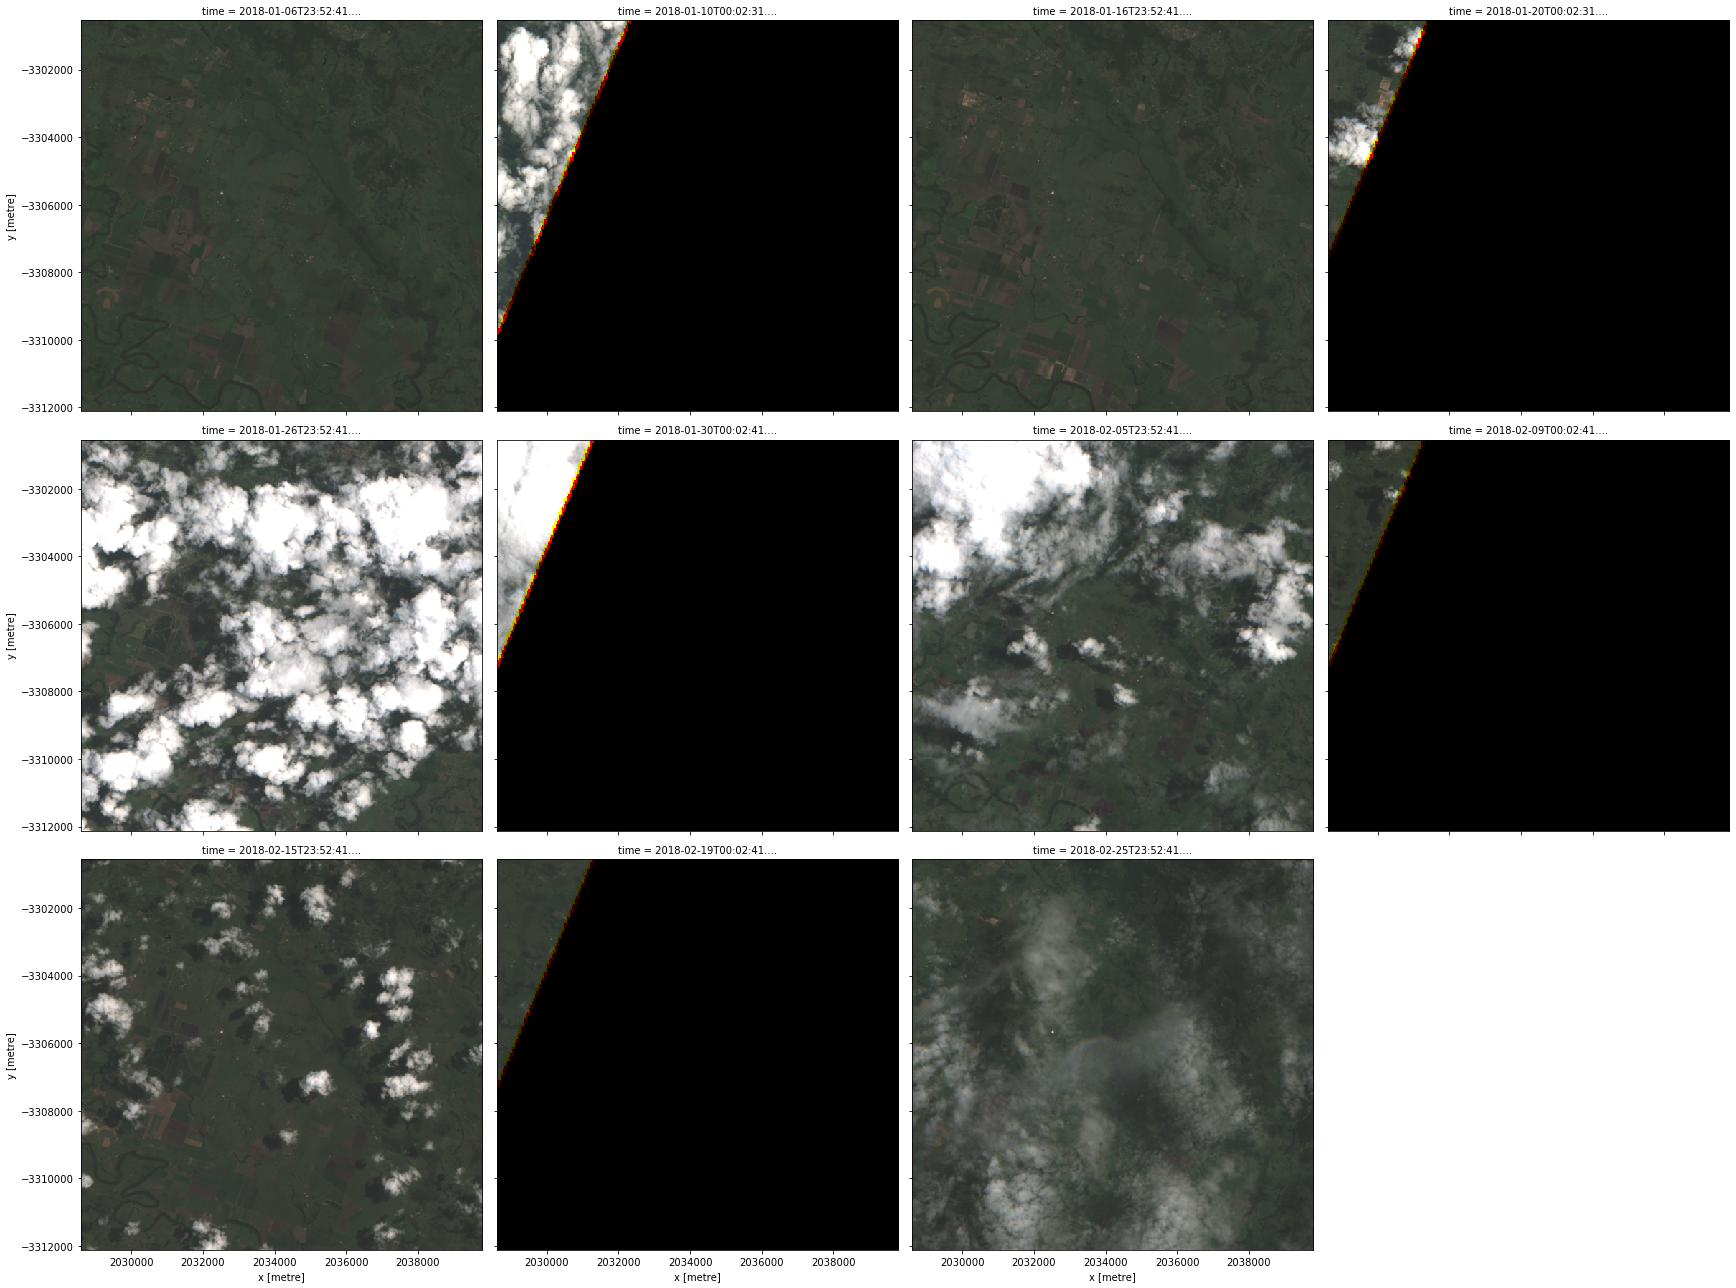

In [2]:
data = dc.load(product="s2a_ard_granule",
               measurements=["nbart_blue", "nbart_green", "nbart_red", "fmask"],
               output_crs="EPSG:3577",
               resolution=[-20, 20],
               resampling={
                   "fmask": "nearest",
                   "*": "average"
               },
               **query)

rgb(data, col="time")


These images show that our area of interest intersects only partially with the satellite track, and therefore some areas in the image have no observed data.

The absence of satellite observation is indicated by a "nodata" value for the band.

In [3]:
data.nbart_red

<xarray.DataArray 'nbart_red' (time: 11, y: 579, x: 560)>
array([[[ 392,  431, ...,  265,  265],
        [ 423,  354, ...,  260,  259],
        ...,
        [ 544,  554, ...,  302,  305],
        [ 535,  563, ...,  310,  330]],

       [[ 749,  722, ..., -999, -999],
        [ 755,  836, ..., -999, -999],
        ...,
        [-999, -999, ..., -999, -999],
        [-999, -999, ..., -999, -999]],

       ...,

       [[ 433,  421, ..., -999, -999],
        [ 458,  404, ..., -999, -999],
        ...,
        [-999, -999, ..., -999, -999],
        [-999, -999, ..., -999, -999]],

       [[ 453,  469, ...,  891,  992],
        [ 467,  434, ..., 1024, 1076],
        ...,
        [ 722,  732, ...,  543,  565],
        [ 697,  692, ...,  586,  587]]], dtype=int16)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-06T23:52:41.026000 ... 2018-02-25T23:52:41.026000
  * y        (y) float64 -3.301e+06 -3.301e+06 ... -3.312e+06 -3.312e+06
  * x        (x) float64 2.029e+06 2.029e+06 2.029e+0

We see that the `nodata` attribute reports the value -999, and we also see some of the pixels have that value.

## Masking out invalid data



We now mask out the no data pixels.
Those nodata pixels will now have the more conventional NaN value.

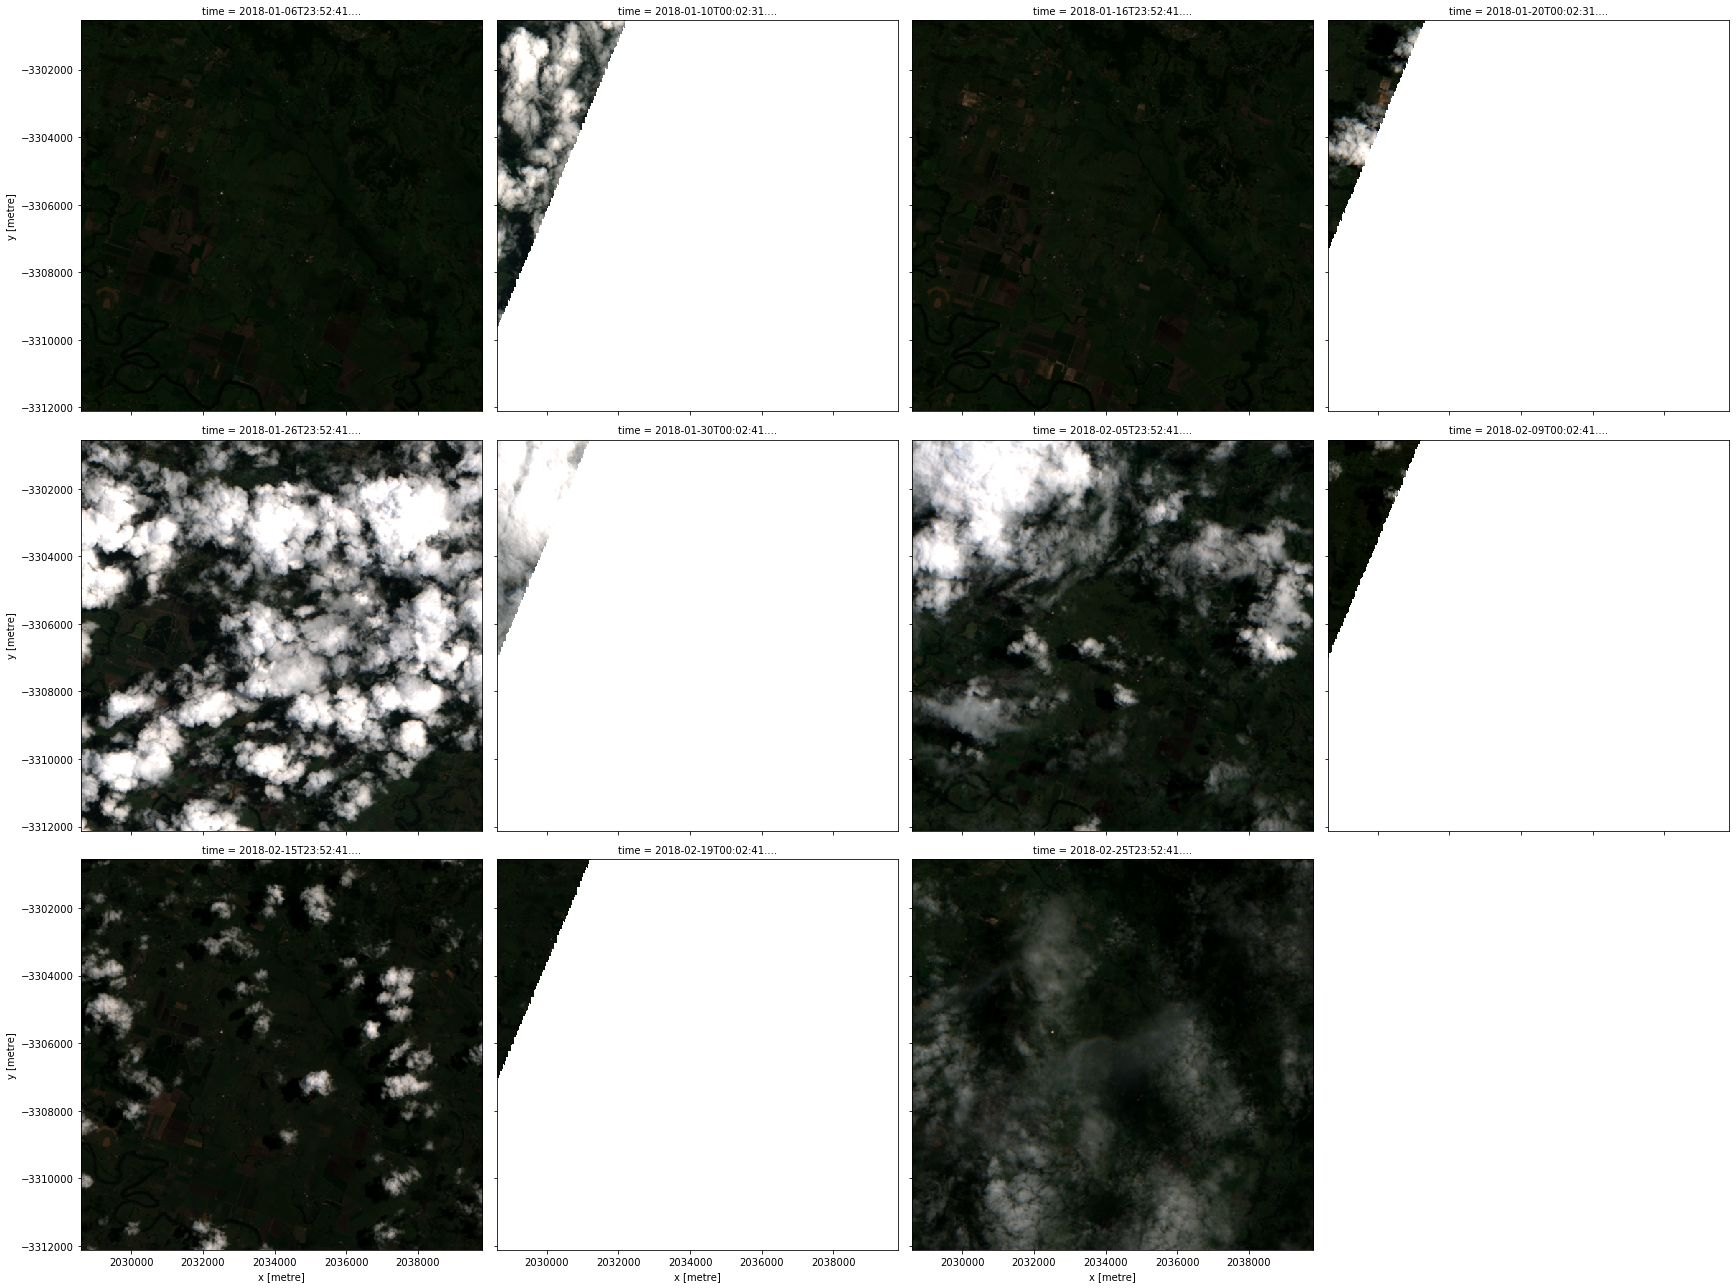

In [4]:
valid_data = mask_invalid_data(data)

rgb(valid_data, col='time')

In [5]:
valid_data.nbart_red

<xarray.DataArray 'nbart_red' (time: 11, y: 579, x: 560)>
array([[[ 392.,  431., ...,  265.,  265.],
        [ 423.,  354., ...,  260.,  259.],
        ...,
        [ 544.,  554., ...,  302.,  305.],
        [ 535.,  563., ...,  310.,  330.]],

       [[ 749.,  722., ...,   nan,   nan],
        [ 755.,  836., ...,   nan,   nan],
        ...,
        [  nan,   nan, ...,   nan,   nan],
        [  nan,   nan, ...,   nan,   nan]],

       ...,

       [[ 433.,  421., ...,   nan,   nan],
        [ 458.,  404., ...,   nan,   nan],
        ...,
        [  nan,   nan, ...,   nan,   nan],
        [  nan,   nan, ...,   nan,   nan]],

       [[ 453.,  469., ...,  891.,  992.],
        [ 467.,  434., ..., 1024., 1076.],
        ...,
        [ 722.,  732., ...,  543.,  565.],
        [ 697.,  692., ...,  586.,  587.]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-06T23:52:41.026000 ... 2018-02-25T23:52:41.026000
  * y        (y) float64 -3.301e+06 -3.301e+06 ... -3.312e+06 -3.312e+06
  

## Cloud-free images

### Creating the clear-pixel mask

We create a mask by specifying conditions that our pixels must satisfy.
To do that, we first look at the flags definition of the `fmask` band.

In [6]:
data.fmask.attrs["flags_definition"]

{'fmask': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'nodata',
   '1': 'valid',
   '2': 'cloud',
   '3': 'shadow',
   '4': 'snow',
   '5': 'water'},
  'description': 'Fmask'}}

It says that the value indicating valid pixels in 1, among other things.
But we will only need the label (not the value) to create a mask.

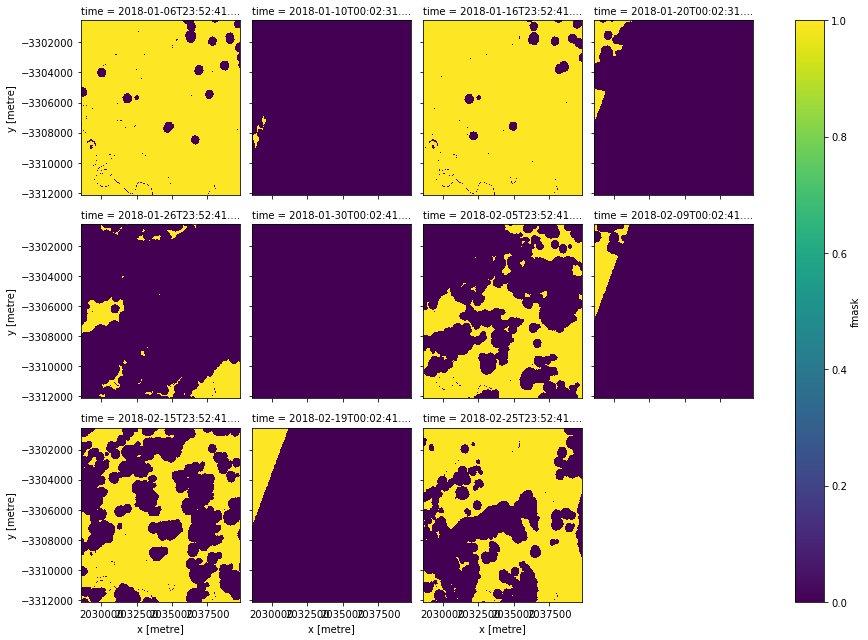

In [7]:
mask = make_mask(data.fmask, fmask="valid")

mask.plot.imshow(col="time", col_wrap=4)

### Applying the clear-pixel mask

We can now get the cloud-free image we want.

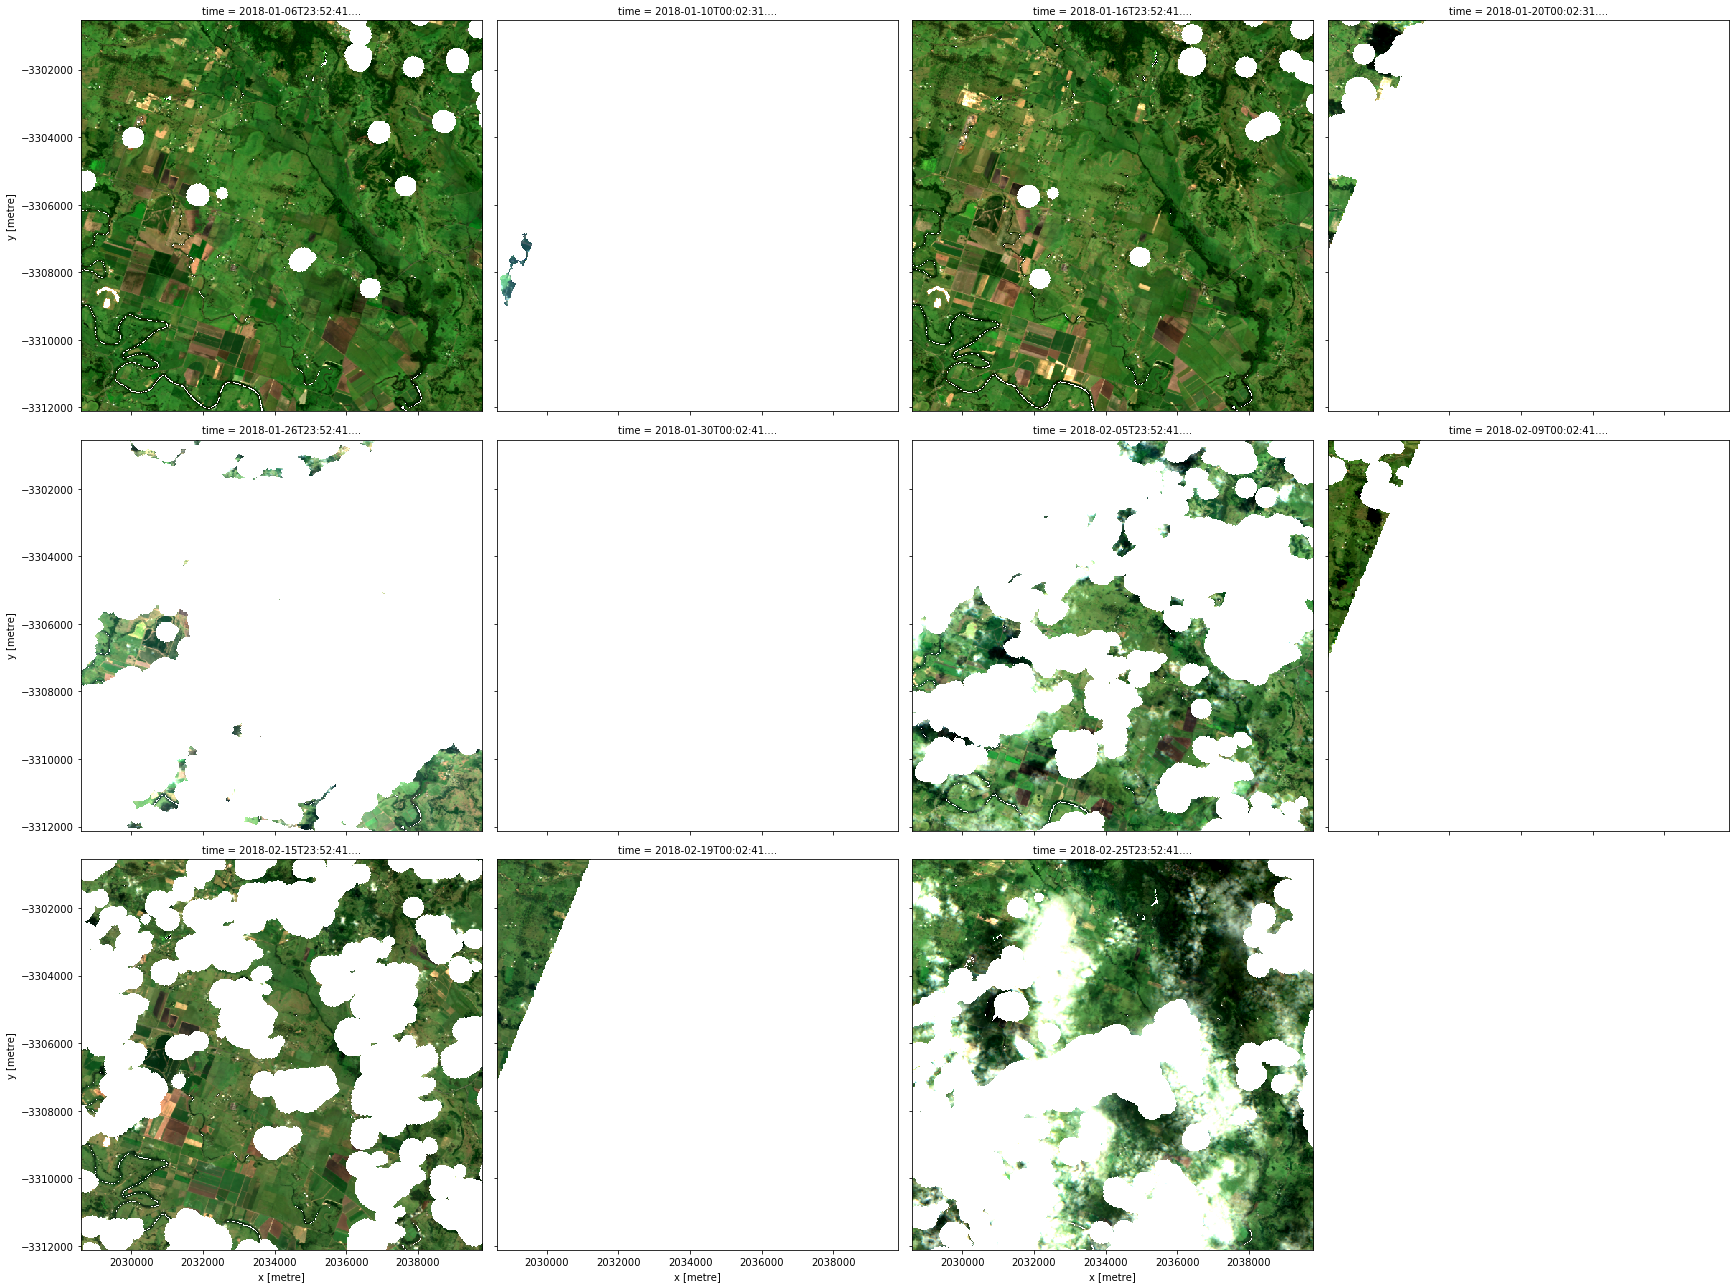

In [8]:
cloud_free = data.where(mask)

rgb(cloud_free, col="time")

Note that we used the `data` that did not have the invalid data (no data) masked, and not `valid_data` which had it masked.
This is because when we created the mask for only the `valid` pixels, it also masked out the `nodata` pixels as reported in the `fmask` band.

## Mask dilation

Sometimes we want our cloud masks to be more conservative and mask out more than just the pixels that `fmask` classified as cloud or cloud shadow.
That is, sometimes we want a buffer around the cloud and the shadow.
We can achive this by dilating the mask.

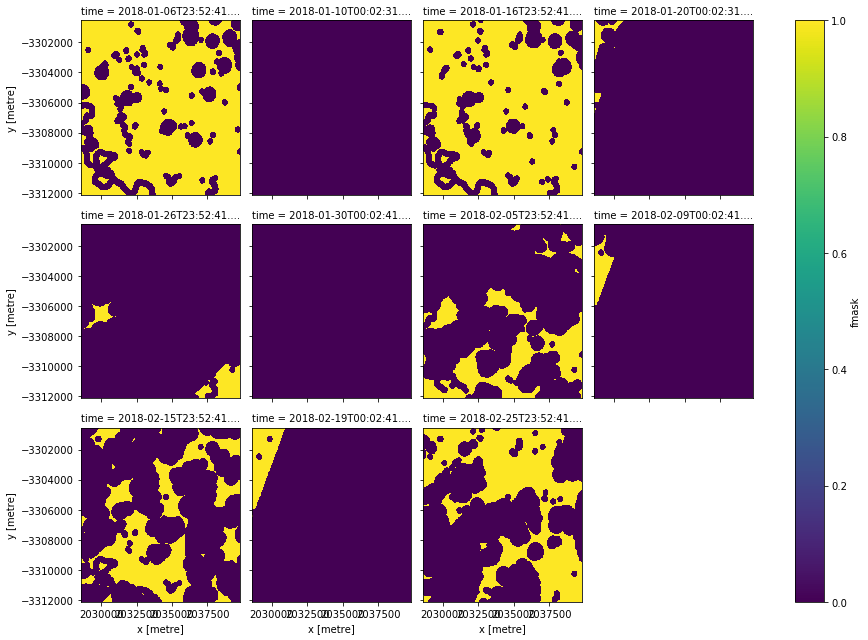

In [9]:
dilation_in_pixels = 10


def dilate(array):
    """
    Dilation e.g. for the mask.
    """
    y, x = numpy.ogrid[
        -dilation_in_pixels : (dilation_in_pixels + 1),
        -dilation_in_pixels : (dilation_in_pixels + 1),
    ]
    # disk-like radial dilation
    kernel = (x * x) + (y * y) <= (dilation_in_pixels + 0.5) ** 2
    return ~scipy.ndimage.binary_dilation(
        ~array.astype(numpy.bool), structure=kernel.reshape((1,) + kernel.shape)
    )


buffered_mask = xarray.apply_ufunc(dilate, mask, keep_attrs=True)

buffered_mask.plot.imshow(col="time", col_wrap=4)

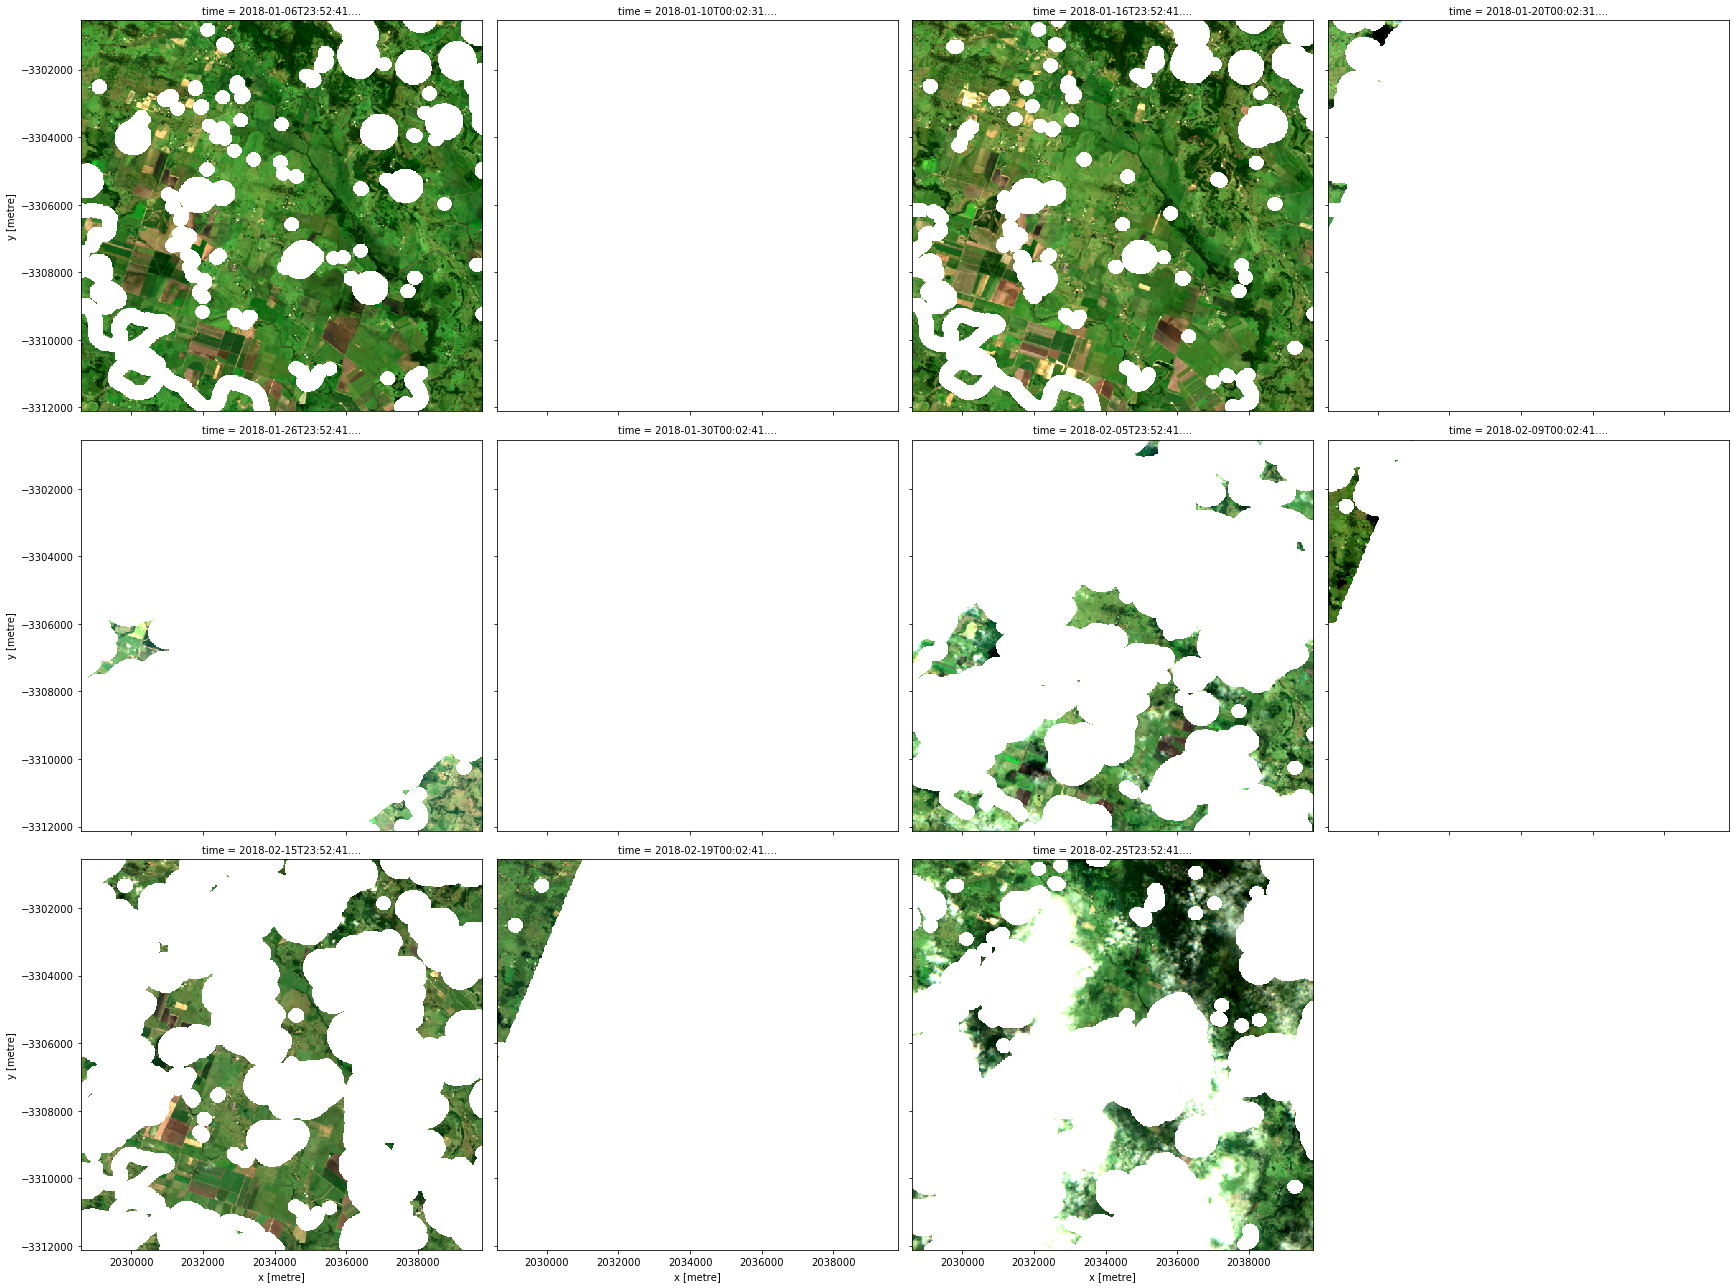

In [10]:
buffered_cloud_free = data.where(buffered_mask)

rgb(buffered_cloud_free, col="time")

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible `datacube` version:** 

In [11]:
print(datacube.__version__)

1.7+43.gc873f3ea


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)